### Анализ факторов, влияющих на цену посуточной аренды квартир в Москве

## Описание:

Цель проекта — исследовать рынок посуточной аренды жилья в Москве и выявить, какие факторы оказывают наибольшее влияние на цену аренды.

### Источник данных

Данные собирались с помощью автоматического парсинга с популярной онлайн-площадки:
- [realty.yandex.ru](https://realty.yandex.ru/moskva/snyat/kvartira/posutochno/)

Для парсинга использовались `selenium` и `webdriver-manager`.

### Что анализируется

В ходе анализа исследуются следующие группы признаков:

- **Локация**: станция метро, адрес, район;
- **Физические параметры**: площадь, этаж, этажность, год постройки, высота потолков;
- **Составные характеристики**: тип санузла, отделка, удобства, наличие предоплаты и т.д.;
- **Показатели эффективности**: цена за квадратный метр.

Анализ включает:
- очистку и нормализацию данных;
- извлечение признаков из полуструктурированных блоков (списки характеристик);
- расчет производных признаков;
- визуализацию распределений и зависимостей;
- поиск выбросов и нетипичных объектов.

Проект завершён интерпретацией ключевых закономерностей и может быть использован как основа для ценообразования, рекомендательных систем и моделирования арендного спроса.


In [1]:
import sys
import os
import ast
import pandas as pd

# Добавляем путь к ../scripts
sys.path.append(os.path.abspath(os.path.join("..", "scripts")))

from parser import collect_rent_offers
from clean_data import clean_rent_offer_data
from eda import run_eda
from analyze_distributions import analyze_numeric_column, plot_distribution, analyze_all, calculate_additional_columns
import analyze_price_factors
from analyze_special_cases import (
    prepare_dataframe,
    analyze_by_build_decade,
    analyze_price_by_location,
    analyze_price_per_sqm,
    find_smallest_most_expensive
)

# Загрузка данных

Парсинг реализован в модуле `parser.py`. Ниже предоставлена ячейка для запуска парсинга. В ней вы можете указать
количество страниц, которые хотите спарсить, а также задержку перед началом парсинга страницы со списком офферов и
началом парсинга каждого оффера. Задержка нужна, чтобы страница успела загрузиться.

---

Парсинг с аргументами по умолчанию занимает примерно 40 минут. В проекте уже есть загруженные и подготовленные
данные, которые можно использовать для анализа. Они собирались пару часов с большей выборкой, чем представлено в
блоке кода ниже.

In [ ]:
# collect_rent_offers(num_pages=16, delay_list=3, delay_offer=1)

# Очистка данных и подготовка к анализу

## Этап 1. Очистка данных

**Что сделано:**

- Извлечены числовые признаки из текстовых полей:
  - `общая`, `жилая`, `кухня`, `потолки`, `этаж`, `год постройки`
- Выделены категориальные признаки:
  - `bathroom_type` (раздельный / совмещённый)
  - `renovation_type` (тип отделки: косметический / евро / дизайнерский)
- Из полей `technical_info`, `building_info`, `amenities` удалены те элементы, которые были перенесены в отдельные столбцы
- `price` очищена от символов и преобразована в `int`
- Все преобразования сохранены в `processed_offers.csv`

**Почему это важно:**

- Все ключевые признаки приведены к числовому или категориальному формату
- Исключено дублирование информации
- Подготовлены структурированные данные для анализа и визуализаций

---

## Этап 2. EDA

**Что сделано:**

- Определены:
  - список колонок
  - типы данных (`float64`, `object`, и т.д.)
  - количество пропусков
  - количество уникальных значений
  - примеры значений (до 5 на колонку)

---

## Выводы по данным
- Основные пропуски связаны с площадями (жилая, кухня) и дополнительной информацией о доме (подъезды, квартиры).
- Поля `price`, `square_meters`, `floor`, `build_year` — почти полные, подходят для анализа и визуализаций.
- Пропуски в `renovation_type` и `bathroom_type` отражают отсутствие этих данных в карточках — это информативно.

- Все извлекаемые значения (включая `technical_info`, `building_info`, `amenities`, `tags`) представлены **структурированными шаблонами** или **ограниченным числом категорий**.
- Мы **не анализируем произвольный текст** (как, например, отзывы, описания или комментарии).
- Обработка сводится к распознаванию регулярных выражений, а не семантическому анализу.
- Примеры:
  - `Отделка — косметический ремонт` → тип отделки
  - `Санузел совмещённый` → тип санузла
  - `9 этажей`, `60 квартир`, `Дом 1981 г.` → явно структурированные форматы

Таким образом, **ни морфологическая нормализация, ни токенизация не требуются**, поскольку обработка опирается на фиксированные словесные шаблоны, а не на свободный текст.

---

Данные успешно подготовлены к дальнейшему анализу: визуализациям, поиску закономерностей, построению моделей и формулировке выводов.


In [ ]:
# Задаём пути
input_path = os.path.abspath(os.path.join("..", "data", "rent_offers.csv"))
output_path = os.path.abspath(os.path.join("..", "data", "processed_offers.csv"))

# Запускаем очистку
clean_rent_offer_data(input_path, output_path)

In [2]:
eda_path = os.path.abspath(os.path.join("..", "data", "processed_offers.csv"))
eda_table = run_eda(eda_path)

# Отображение таблицы
import pandas as pd
from IPython.display import display

pd.set_option("max_colwidth", 100)
display(eda_table)

,column,dtype,nulls,unique,examples
0,link,object,0,592,"https://realty.yandex.ru/offer/5676176164688311553/, https://realty.yandex.ru/offer/701768637816..."
1,price,int64,0,127,"3800, 4000, 3500, 5500, 14900"
2,address,object,2,376,"проспект Вернадского, Волгоградский проспект, Большая Грузинская улица, Красногорский бульвар, Л..."
3,metro,object,0,214,"Юго-Западная, Пролетарская, Баррикадная, Пенягино, Динамо"
4,amenities,object,0,269,"['19,1 м²', 'Балкон', 'Вид из окон во двор', 'Интернет', 'Мебель', 'Мебель на кухне', 'Телевизор..."
5,building_info,object,0,498,"['Серия П-43', 'Панельное здание', '2,7 м потолки', 'Лифт', 'Мусоропровод', 'Открытая парковка',..."
6,tags,object,0,60,"['без комиссии', 'залог', 'цена с КУ', 'посуточная аренда'], ['без комиссии', 'залог', 'без торг..."
7,square_meters,float64,0,99,"36.0, 42.0, 45.0, 35.0, 180.0"
8,living_meters,float64,299,66,"19.1, 26.0, 20.0, 18.9, 22.0"
9,kitchen_meters,float64,370,37,"8.2, 8.0, 5.0, 7.9, 9.0"


## Анализ и визуализация

### Анализ распределений и выбросов по числовым признакам

#### Цель

Проанализировать ключевые числовые признаки, встречающиеся в данных об аренде недвижимости:
- выявить нормальные границы значений;
- найти выбросы;
- понять диапазоны, в которых сосредоточено большинство объектов.

Анализ проводится по всем количественным полям, включая как физические характеристики объектов (площадь, этаж), так и рассчитанные метрики (например, доля жилой площади).

---

#### Методы

Для каждого числового признака рассчитаны:
- количество наблюдений (заполненных значений);
- минимум, максимум;
- среднее, медиана;
- квартиль 1 (Q1) и квартиль 3 (Q3);
- межквартильный размах (IQR);
- границы выбросов:
  - нижняя = Q1 − 1.5 × IQR
  - верхняя = Q3 + 1.5 × IQR
- количество выбросов (значений за пределами этих границ).

---

#### Интерпретация результатов

##### Цена аренды (price)
Большинство значений лежит между 2500 и 4200 ₽ в сутки.
Верхние выбросы начинаются с 6750 ₽ — это может отражать элитную аренду.
Количество выбросов: **61 из 592** (~10%).
Квартиры за 17 000 ₽ в сутки в выборке не массовые. И вряд ли массово снимаются.

##### Общая площадь (square_meters)
Медиана — 36 м², основная масса значений укладывается в диапазон до 75 м².
Площади свыше 100 м² — редки и представляют интерес только для узкого сегмента.
10 м² — инженерный минимум, теоретически укладывается в закон физики.

##### Жилая площадь (living_meters)
Медиана — 20 м².
Значения выше 50 м² — выбросы, чаще всего в больших или нестандартных объектах.
Жилая площадь в 150 м² — если не считать кухню, скорее всего, это что-то с колоннами.

##### Площадь кухни (kitchen_meters)
Большинство значений сосредоточено между 7 и 10 м².
Кухни более 14.5 м² — редкость.
Кухня в 3 м² — скорее сценарий, чем помещение.

##### Высота потолков (ceiling_height)
Основной диапазон — от 2.6 до 3 м.
Потолки выше 3.5 м — редкость и сигнал о нестандартной/дорогой недвижимости.

##### Этаж (floor)
Медианный этаж — 5.
Выбросы выше 20 этажа — скорее всего, башни или высотные комплексы.

##### Год постройки (build_year)
Медиана — 1980, диапазон — от 1893 до 2024.
Распределение би-модальное: старый фонд и новые ЖК.

##### Этажей в доме (building_floors)
Типичный дом — 7–14 этажей.
Максимум в 85 этажей — признак высотной застройки.
Если в доме 85 этажей, а вы живёте на первом — лифт используется только соседом сверху.

##### Квартир в доме (apartments_count)
Медиана — 143, большинство домов укладываются до 300.
1947 квартир — потенциально многосекционный или комплекс на одной улице.
1947 квартир в одном здании — хорошая мотивация для изучения crowd dynamics.

##### Подъездов в доме (entrances_count)
Медиана — 4.
Значения от 10 и выше встречаются редко и характерны для крупных домов.
24 подъезда — это уже почти муниципалитет.

##### Доля жилой площади (living_ratio)
Норма — 0.5–0.7.
Ниже 0.4 — нестандартное планировочное решение или дом с огромной кухней.
Жилая доля в 0.3 — кухня и санузел оказались в приоритете.

##### Доля кухни (kitchen_ratio)
Типично — 0.2 ± 0.05.
Значения выше 0.3 — скорее аномалия.

##### Позиция по этажности (floors_diff)
Норма — 0.2–0.8.
Значения > 1 — очевидная ошибка (этаж выше, чем этажность дома).
Если вы живёте выше крыши — или ошибка в данных, или очень креативный девелопер.

##### Квартир на подъезд (density)
Медиана — 40, верхняя граница нормы — ~150.
Значения > 200 — аномально высокая плотность.

---

#### Выводы

- Распределения большинства признаков **асимметричны**, с выраженными правыми "хвостами".
- Во всех признаках есть выбросы, особенно в `price`, `square_meters`, `ceiling_height`, `floor`, `density`.
- Выбросы следует либо отдельно учитывать, либо исключать при построении моделей.
- Признаки, такие как `living_ratio` и `kitchen_ratio`, демонстрируют стабильное поведение и могут использоваться в качестве нормализованных показателей.

Анализ даёт чёткое понимание пределов нормы для каждого числового признака и позволяет лучше отфильтровать нетипичные объекты при построении моделей или визуализаций.



=== Анализ признака: Цена, ₽ (price) ===
Количество: 592
Минимум: 1500.0
1 квартиль (Q1): 2500.0
Медиана: 3100.0
Среднее: 3947.25
3 квартиль (Q3): 4200.0
Максимум: 17000.0
Ст. отклонение: 2410.47
IQR: 1700.0
Нижняя граница выбросов: 0
Верхняя граница выбросов: 6750.0
Кол-во выбросов: 61


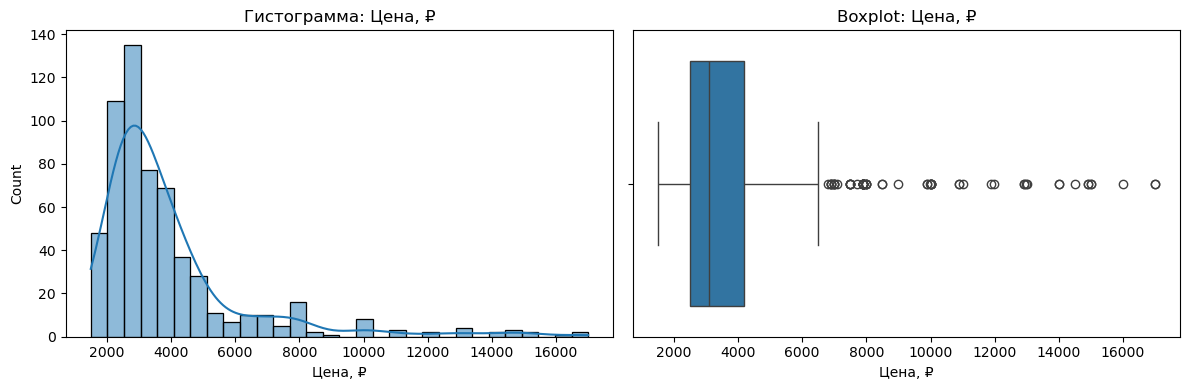


=== Анализ признака: Общая площадь, м² (square_meters) ===
Количество: 592
Минимум: 10.0
1 квартиль (Q1): 25.0
Медиана: 36.0
Среднее: 39.92
3 квартиль (Q3): 45.0
Максимум: 215.0
Ст. отклонение: 22.9
IQR: 20.0
Нижняя граница выбросов: 0
Верхняя граница выбросов: 75.0
Кол-во выбросов: 30


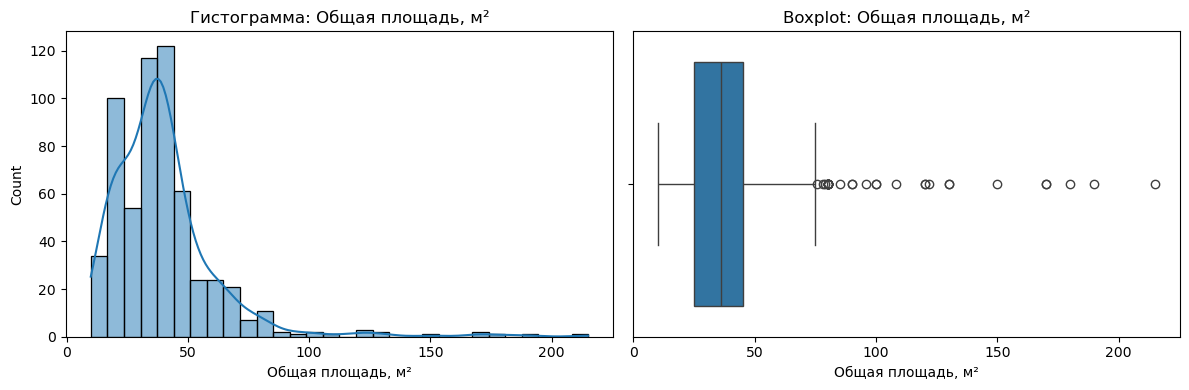


=== Анализ признака: Жилая площадь, м² (living_meters) ===
Количество: 293
Минимум: 7.0
1 квартиль (Q1): 18.0
Медиана: 20.0
Среднее: 27.19
3 квартиль (Q3): 31.0
Максимум: 150.0
Ст. отклонение: 17.44
IQR: 13.0
Нижняя граница выбросов: 0
Верхняя граница выбросов: 50.5
Кол-во выбросов: 19


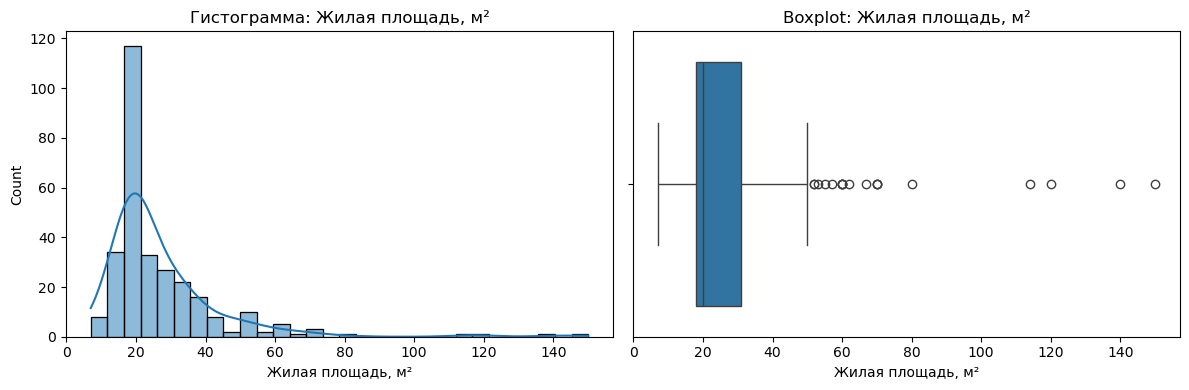


=== Анализ признака: Площадь кухни, м² (kitchen_meters) ===
Количество: 222
Минимум: 3.0
1 квартиль (Q1): 7.0
Медиана: 9.0
Среднее: 9.52
3 квартиль (Q3): 10.0
Максимум: 40.0
Ст. отклонение: 4.32
IQR: 3.0
Нижняя граница выбросов: 2.5
Верхняя граница выбросов: 14.5
Кол-во выбросов: 21


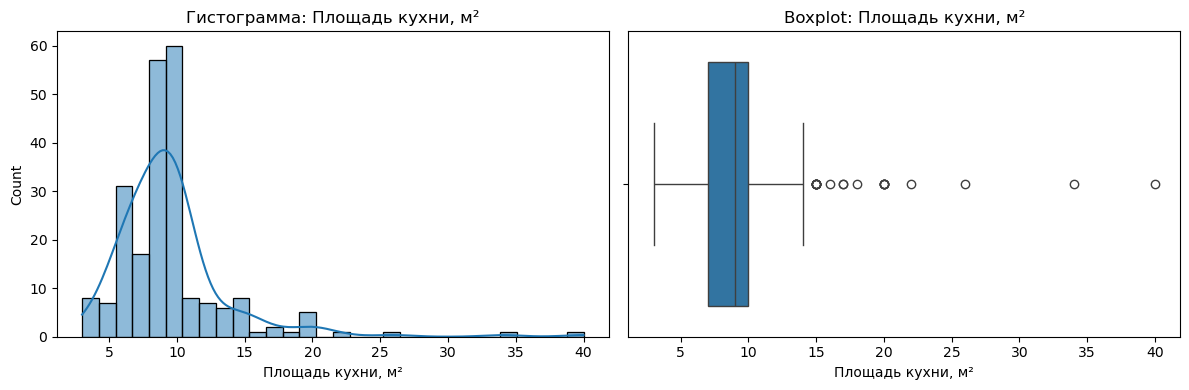


=== Анализ признака: Высота потолков, м (ceiling_height) ===
Количество: 490
Минимум: 1.58
1 квартиль (Q1): 2.64
Медиана: 2.79
Среднее: 2.95
3 квартиль (Q3): 3.0
Максимум: 27.0
Ст. отклонение: 1.54
IQR: 0.36
Нижняя граница выбросов: 2.1
Верхняя граница выбросов: 3.54
Кол-во выбросов: 27


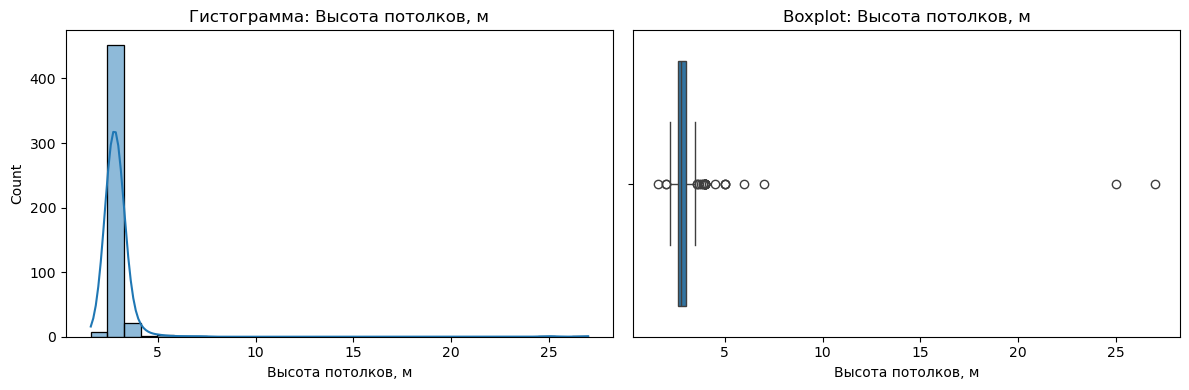


=== Анализ признака: Этаж (floor) ===
Количество: 592
Минимум: 1.0
1 квартиль (Q1): 2.0
Медиана: 5.0
Среднее: 7.27
3 квартиль (Q3): 9.0
Максимум: 80.0
Ст. отклонение: 8.52
IQR: 7.0
Нижняя граница выбросов: 0
Верхняя граница выбросов: 19.5
Кол-во выбросов: 29


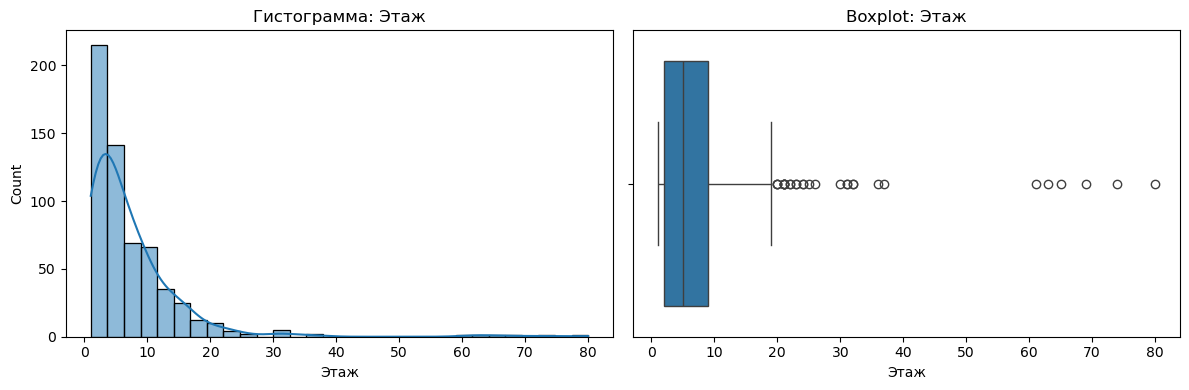


=== Анализ признака: Год постройки (build_year) ===
Количество: 583
Минимум: 1893.0
1 квартиль (Q1): 1963.0
Медиана: 1980.0
Среднее: 1985.58
3 квартиль (Q3): 2018.0
Максимум: 2024.0
Ст. отклонение: 31.64
IQR: 55.0
Нижняя граница выбросов: 1880.5
Верхняя граница выбросов: 2100.5
Кол-во выбросов: 0


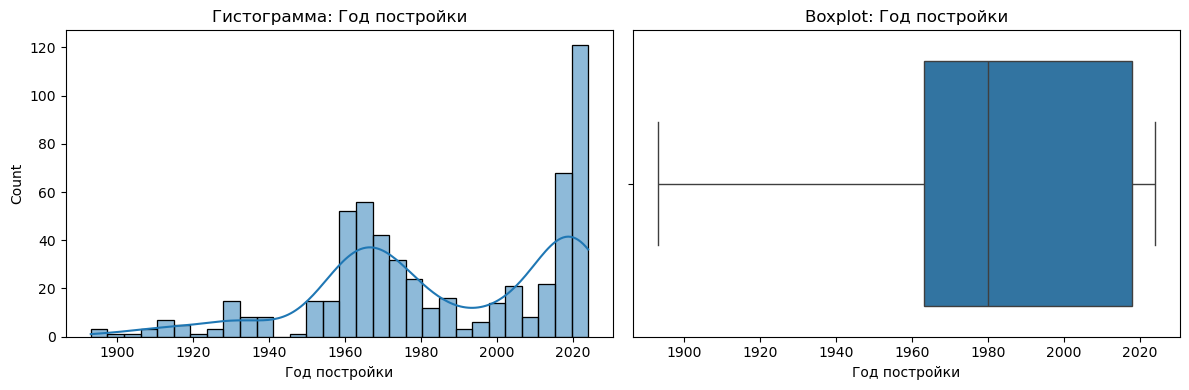


=== Анализ признака: Этажей в доме (building_floors) ===
Количество: 498
Минимум: 3.0
1 квартиль (Q1): 7.0
Медиана: 9.0
Среднее: 11.06
3 квартиль (Q3): 14.0
Максимум: 85.0
Ст. отклонение: 6.08
IQR: 7.0
Нижняя граница выбросов: 0
Верхняя граница выбросов: 24.5
Кол-во выбросов: 17


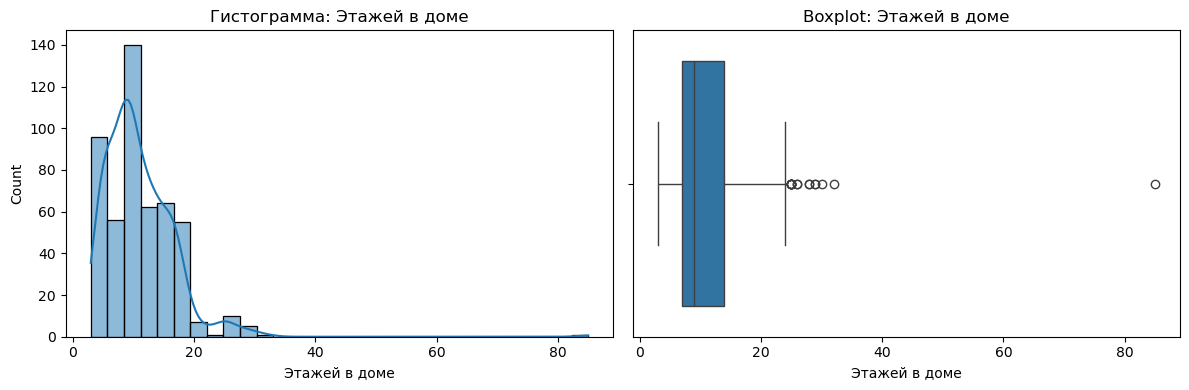


=== Анализ признака: Квартир в доме (apartments_count) ===
Количество: 303
Минимум: 1.0
1 квартиль (Q1): 78.5
Медиана: 143.0
Среднее: 215.82
3 квартиль (Q3): 288.0
Максимум: 1947.0
Ст. отклонение: 214.19
IQR: 209.5
Нижняя граница выбросов: 0
Верхняя граница выбросов: 602.25
Кол-во выбросов: 16


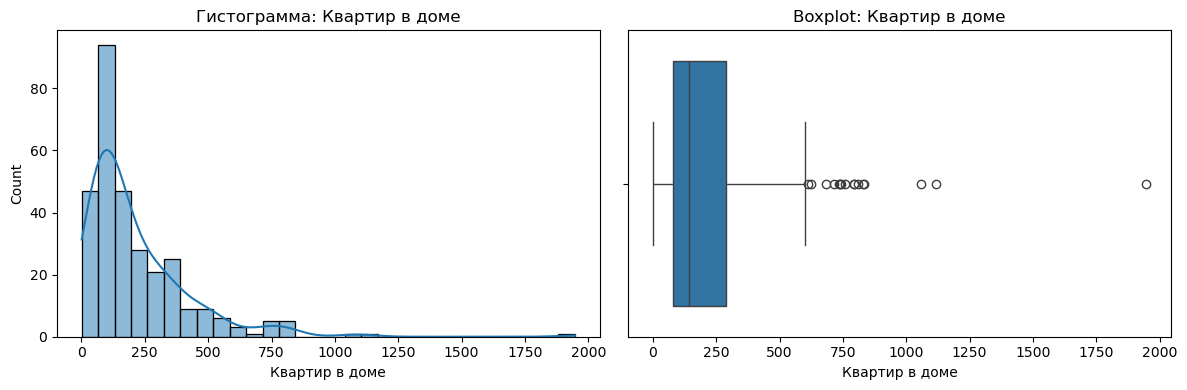


=== Анализ признака: Подъездов в доме (entrances_count) ===
Количество: 372
Минимум: 1.0
1 квартиль (Q1): 2.0
Медиана: 4.0
Среднее: 4.51
3 квартиль (Q3): 6.0
Максимум: 24.0
Ст. отклонение: 3.79
IQR: 4.0
Нижняя граница выбросов: 0
Верхняя граница выбросов: 12.0
Кол-во выбросов: 17


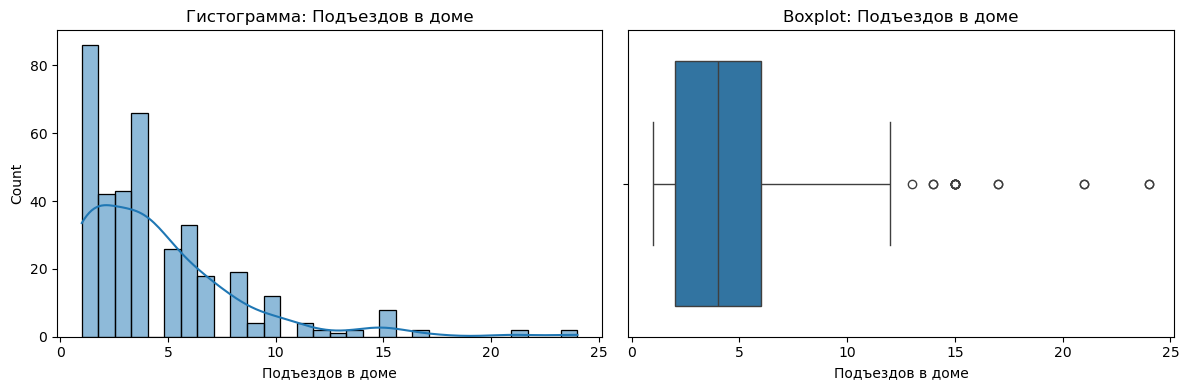


=== Анализ признака: Доля жилой площади (living_ratio) ===
Количество: 293
Минимум: 0.29
1 квартиль (Q1): 0.53
Медиана: 0.6
Среднее: 0.63
3 квартиль (Q3): 0.72
Максимум: 1.0
Ст. отклонение: 0.14
IQR: 0.2
Нижняя граница выбросов: 0.23
Верхняя граница выбросов: 1.02
Кол-во выбросов: 0


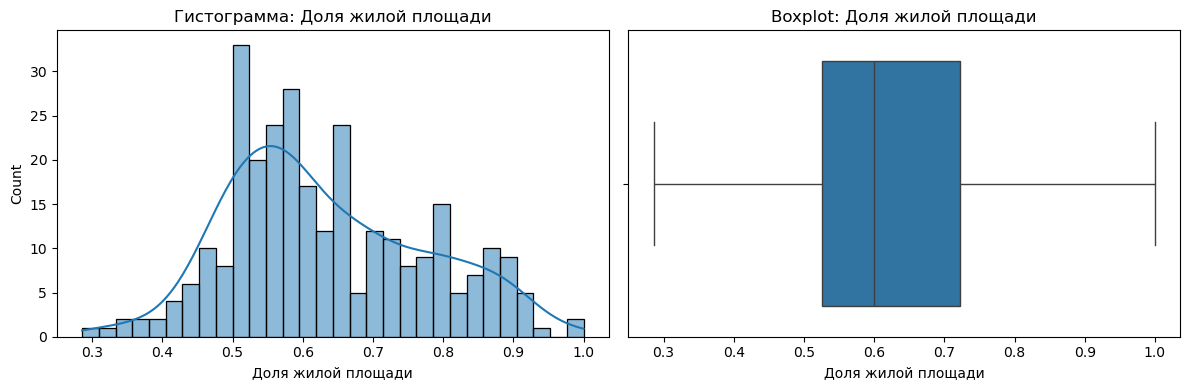


=== Анализ признака: Доля кухни (kitchen_ratio) ===
Количество: 222
Минимум: 0.06
1 квартиль (Q1): 0.16
Медиана: 0.2
Среднее: 0.21
3 квартиль (Q3): 0.25
Максимум: 0.44
Ст. отклонение: 0.06
IQR: 0.09
Нижняя граница выбросов: 0.04
Верхняя граница выбросов: 0.38
Кол-во выбросов: 5


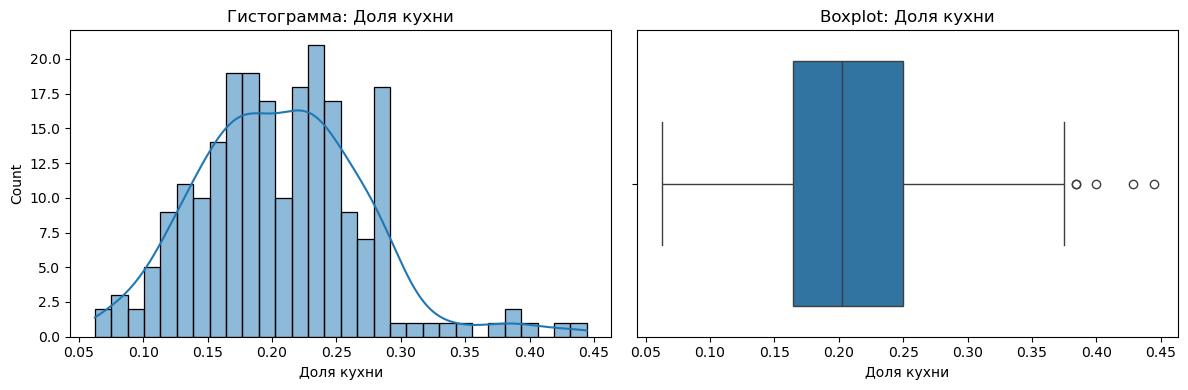


=== Анализ признака: Позиция по этажности (floors_diff) ===
Количество: 498
Минимум: 0.05
1 квартиль (Q1): 0.24
Медиана: 0.56
Среднее: 0.6
3 квартиль (Q3): 0.81
Максимум: 4.62
Ст. отклонение: 0.46
IQR: 0.57
Нижняя граница выбросов: 0
Верхняя граница выбросов: 1.66
Кол-во выбросов: 13


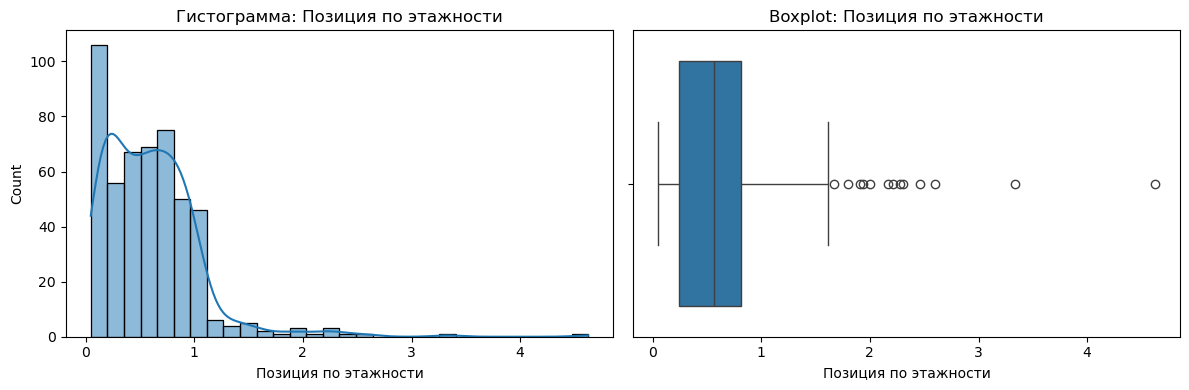


=== Анализ признака: Квартир на подъезд (density) ===
Количество: 299
Минимум: 0.33
1 квартиль (Q1): 20.6
Медиана: 40.0
Среднее: 54.79
3 квартиль (Q3): 72.0
Максимум: 324.5
Ст. отклонение: 42.68
IQR: 51.4
Нижняя граница выбросов: 0
Верхняя граница выбросов: 149.09
Кол-во выбросов: 11


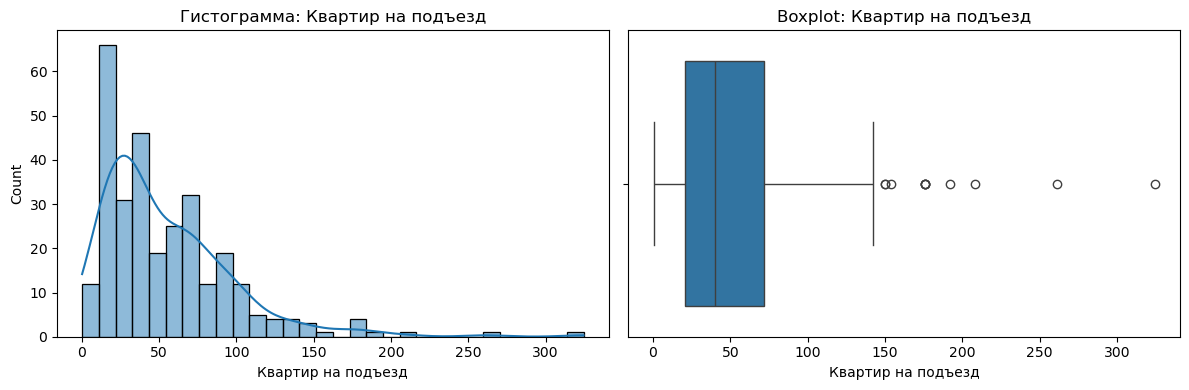

In [3]:
# Загружаем данные
df = pd.read_csv("../data/processed_offers.csv")

# Задаем переменные с русскими названиями
columns_to_analyze = {
    "price": "Цена, ₽",
    "square_meters": "Общая площадь, м²",
    "living_meters": "Жилая площадь, м²",
    "kitchen_meters": "Площадь кухни, м²",
    "ceiling_height": "Высота потолков, м",
    "floor": "Этаж",
    "build_year": "Год постройки",
    "building_floors": "Этажей в доме",
    "apartments_count": "Квартир в доме",
    "entrances_count": "Подъездов в доме",
    "living_ratio": "Доля жилой площади",
    "kitchen_ratio": "Доля кухни",
    "floors_diff": "Позиция по этажности",
    "density": "Квартир на подъезд"
}

# Запуск анализа
analyze_all(df, columns_to_analyze)

### Анализ влияния категориальных и списковых признаков на цену аренды

#### Цель

Понять, какие **нечисловые характеристики** объектов влияют на стоимость посуточной аренды:
- выявить признаки, с которыми цена заметно выше или ниже среднего;
- интерпретировать полученные различия в контексте удобства, расположения и типа недвижимости;
- выделить потенциальные факторы, которые могут служить признаками качества.

---

#### Интерпретация результатов

##### Тип санузла (`bathroom_type`)
- Всего 2 категории: **раздельный** и **совмещённый**.
- Раздельный санузел ассоциируется с более высокой средней ценой: 4525 ₽ против 3713 ₽.

##### Тип отделки (`renovation_type`)
- Лидируют: **дизайнерский ремонт** и **евроремонт**.
- Косметический ремонт уступает по цене почти в полтора раза.

##### Станция метро (`metro`)
- Топ по цене: **Деловой центр**, **Пушкинская**, **Москва-Сити** — все в центральных или деловых районах.
- Антитоп: **Пражская**, **Юго-Восточная**, **Моссельмаш** — удалённые станции с низким спросом.
- _Метро влияет почти так же, как квадратные метры._

##### Адрес (`address`)
- Топ-адреса — центральные улицы и набережные: **Арбат**, **Тверская**, **Архитектора Щусева**.
- Низшие позиции — удалённые районы или окраины.
- _Локация решает: цена падает пропорционально удалённости от центра и известности названия._

##### Удобства (`amenities`)
- Самые "дорогие" удобства: **несколько санузлов**, **посудомойка**, **виды из окон**, **кондиционер**.
- Базовые удобства вроде стиралки, мебели и холодильника уже "встроены" в ожидания.
- _Посудомойка повышает цену больше, чем холодильник. Вид из окон — дороже, чем окна._

##### Теги объявления (`tags`)
- В топе: **предоплата 50%**, **без торга**, **залог** — типичные признаки объектов с высокой уверенностью в спросе.
- "Без комиссии", "посуточная аренда" и "цена с КУ" — ближе к средним.
- _Предоплата 50% — индикатор уверенности владельца, и, возможно, наличия лифта._

##### Информация о доме (`building_info`)
- Существенно повышают цену: **подземная парковка**, **высокие потолки**, **закрытая территория**.
- Признаки типа "3 м потолки" и "застройщик ИНТЕКО" тоже коррелируют с премиальностью.
- _Высота потолков влияет на цену. Видимо, для тех, кто любит мыслить высоко._

---

#### Выводы

- Центральное расположение, отделка высокого класса, удобства премиум-уровня и формальные ограничения (предоплата, торг) — все эти признаки ведут к заметному росту стоимости аренды.
- Удалённые районы, базовая отделка и отсутствие "премиальных тегов" — понижают цену.
- Специфические удобства (посудомойка, вид на улицу) не так очевидны, но дают сильный эффект.
- _В некоторых случаях `tag = 'предоплата 50%'` объясняет цену лучше, чем `square_meters`._

---

Анализ категориальных признаков показал, что влияние на цену распределено неравномерно — есть как явные, так и менее очевидные драйверы. Отделка, условия аренды и даже один конкретный тег могут существенно сдвигать ценовую планку.


Коэффициенты корреляции с ценой аренды:
Цена, ₽                 1.000000
Жилая площадь, м²       0.783160
Общая площадь, м²       0.714161
Площадь кухни, м²       0.486470
Этаж                    0.400767
Доля жилой площади      0.207232
Подъездов в доме        0.102726
Позиция по этажности    0.075392
Высота потолков, м      0.039268
Этажей в доме          -0.027574
Квартир в доме         -0.058538
Квартир на подъезд     -0.142823
Год постройки          -0.162761
Доля кухни             -0.324073
Name: Цена, ₽, dtype: float64


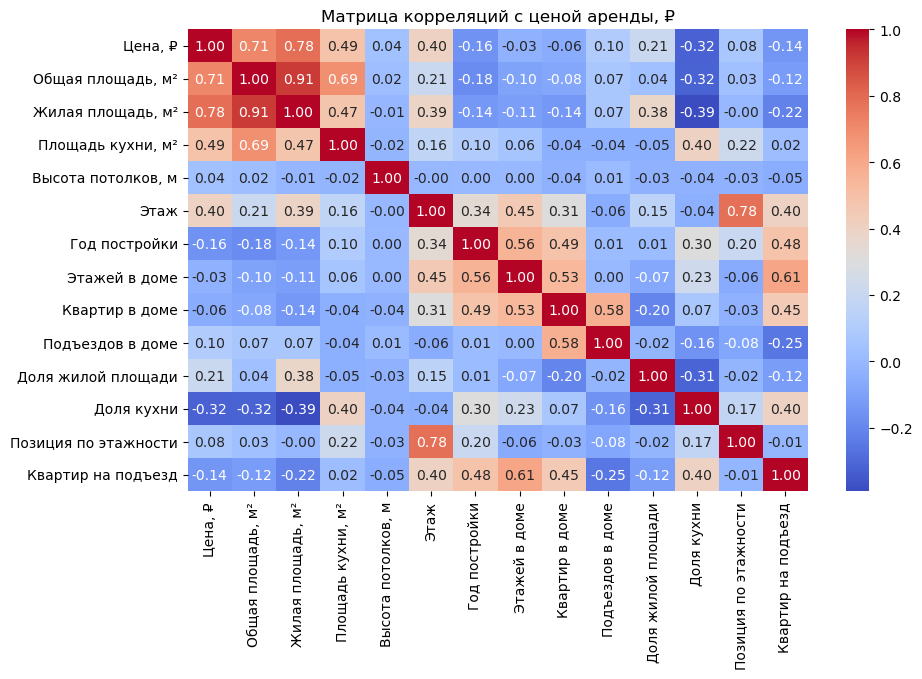


=== Анализ по: bathroom_type ===
Всего категорий: 2

ТОП 2 по средней цене:
bathroom_type
раздельный     4525.47
совмещённый    3713.05
Name: price, dtype: float64

=== Анализ по: renovation_type ===
Всего категорий: 4

ТОП 4 по средней цене:
renovation_type
дизайнерский ремонт     4587.84
евроремонт              4225.61
требуется ремонт        3200.00
косметический ремонт    3025.18
Name: price, dtype: float64

=== Анализ по: metro ===
Всего категорий: 214

ТОП 10 по средней цене:
metro
Деловой центр    13426.86
Пушкинская       11900.00
Таганская        10950.00
Шелепиха         10000.00
Москва-Сити      10000.00
Китай-Город       9500.00
Технопарк         9200.00
Тверская          9133.33
Тургеневская      8433.33
Римская           8000.00
Name: price, dtype: float64

АНТИТОП 10 по средней цене:
metro
Волоколамская            2200.00
Моссельмаш               2200.00
Сокол                    2160.00
Яхромская                2075.25
Лихоборы                 2000.00
Зорге             

In [4]:
df = pd.read_csv("../data/processed_offers.csv")
for col in ["amenities", "tags", "building_info"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df = calculate_additional_columns(df)


# Числовые признаки
numeric_cols = [
    "square_meters", "living_meters", "kitchen_meters", "ceiling_height",
    "floor", "build_year", "building_floors", "apartments_count", "entrances_count",
    "living_ratio", "kitchen_ratio", "floors_diff", "density"
]
analyze_price_factors.analyze_numeric_corr(df, numeric_cols)

# Категории
analyze_price_factors.analyze_categorical_impact(df, "bathroom_type")
analyze_price_factors.analyze_categorical_impact(df, "renovation_type")
analyze_price_factors.analyze_categorical_impact(df, "metro")
analyze_price_factors.analyze_categorical_impact(df, "address")

# Списковые поля (корректный анализ по вхождениям)
analyze_price_factors.analyze_list_column_impact(df, "amenities")
analyze_price_factors.analyze_list_column_impact(df, "tags")
analyze_price_factors.analyze_list_column_impact(df, "building_info")

### Расширенный анализ данных аренды: эпохи постройки, локации и цена за м²

#### 1. Анализ по эпохам постройки (`build_year`)

##### Цель
Понять, как изменяется стоимость аренды в зависимости от периода постройки здания. Предположение: наиболее высокая
цена будет у самых новых и самых старых домов.

##### Реализация
- Год постройки (`build_year`) разбит на группы:
  - `до 1960`
  - `1960–1969`, `1970–1979`, … `2020–2029`
- Для каждой группы рассчитана средняя цена аренды.
- Построен barplot.

##### Интерпретация
- Самая высокая средняя цена у категории **«до 1960»** — возможны исторические здания в центре.
- Новые дома 2000-х тоже выше среднего.
- Дома 1980-х — самые «экономичные» по аренде.

---

#### 2. Анализ по `metro` и `address`

##### Цель
Выявить локальные различия в ценах: где аренда самая дорогая — по станциям метро и по улицам.

##### Реализация
- Рассчитана средняя цена аренды по каждому `metro` и `address`.
- Отобраны топ-20 по цене.
- Визуализированы barplot'ы и таблицы с градиентной заливкой.

##### Интерпретация
- Самые дорогие станции метро — **Деловой центр**, **Пушкинская**, **Таганская**.
- Топ-адреса сосредоточены в **ЦАО**: **Арбат**, **Тверская**, **Котельническая набережная**.
- Отлично проявляется эффект «престижности» и **близости к деловому центру**.

_Фактор геолокации — один из ключевых драйверов цены. Не квадратные метры, а координаты._

---

#### 3. Анализ цены за квадратный метр (`price_per_sqm`)

##### Цель
Выявить влияние площади на цену и выявить объекты с завышенной или заниженной стоимостью аренды на единицу площади.

##### Реализация
- Добавлен признак: `price_per_sqm = price / square_meters`
- Построено распределение значений.
- Выведены ключевые статистики (`min`, `max`, `медиана` и пр.)
- Отобраны топ-5 квартир с наибольшей ценой за м².

##### Интерпретация
- Медианная стоимость аренды за м² — **93.6 ₽**, средняя — **108 ₽**.
- В распределении наблюдается правосторонняя асимметрия.
- Квартиры с ценой за м² выше **300 ₽** — скорее исключение, чем правило.

_Цена за м² даёт более объективное сравнение квартир. Особенно полезно при анализе студий, однушек и элитных объектов._

---

#### 4. Самая дорогая (за м²) и при этом маленькая квартира

##### Цель
Ироничный поиск объекта, который одновременно:
- очень маленький по площади,
- очень дорогой за м².

##### Реализация
- Отобрана квартира с максимальной `price_per_sqm` при минимальной `square_meters`.

##### Результат
- **Площадь**: 15.0 м²
- **Цена**: 6990 ₽
- **Цена за м²**: **466.00 ₽/м²**
- **Адрес**: 1-й Красногвардейский проезд
- **Метро**: Деловой центр

_Объект явно не рассчитан на долговременное проживание. Скорее это точка роста для инвестора с хорошей фантазией и слабым чувством иронии._

---

#### Общие выводы

- Аренда в Москве — это сложный конструкт из признаков: площадь, год, станция метро, адрес, этаж и даже кухонный коэффициент.
- География и тип здания часто доминируют над физическими характеристиками.
- Анализ за м² — мощный инструмент для выявления неочевидных переоценённых квартир.

_Сухие метры без контекста не объясняют цену. А вот сочетание признаков — уже вполне._



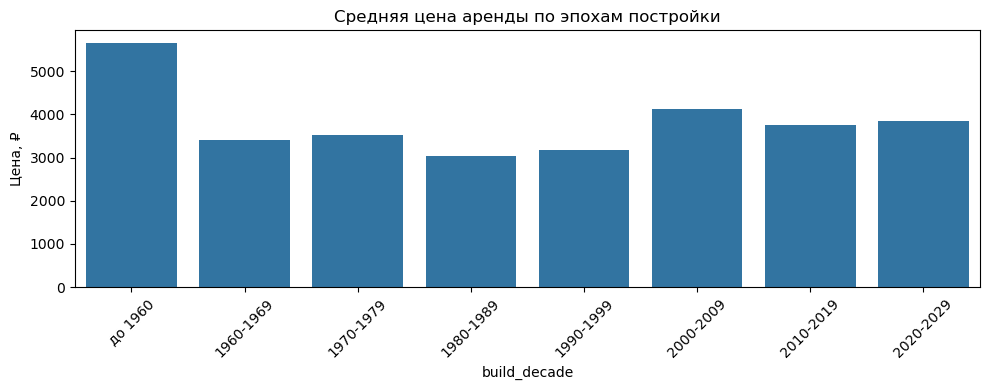

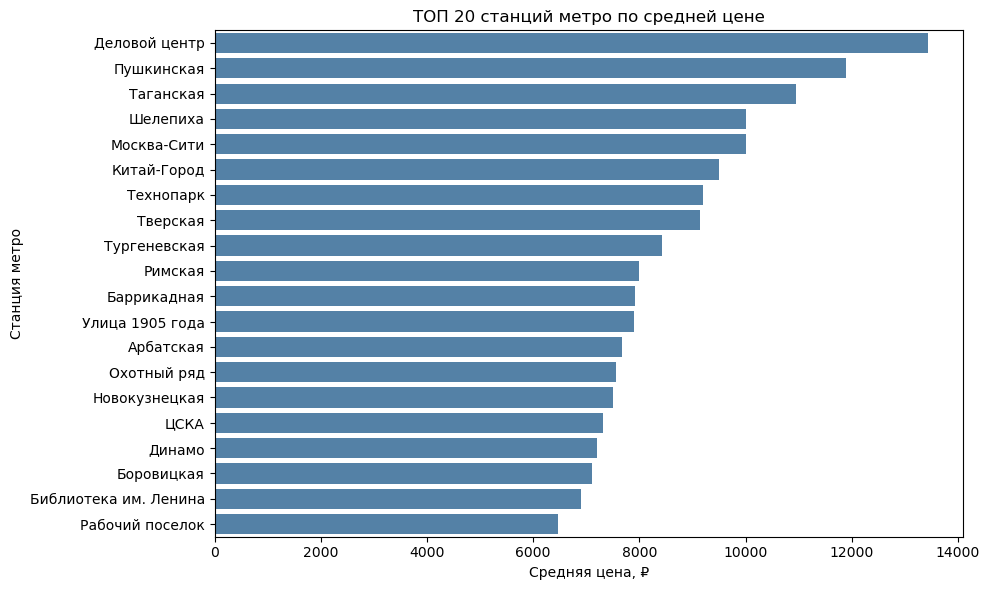

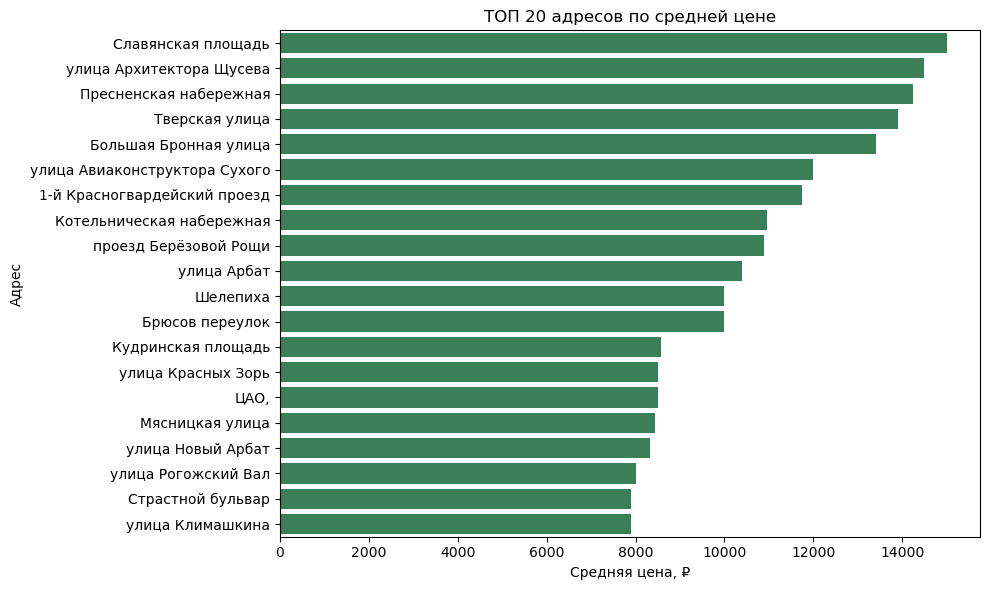

,avg_price
metro,
Деловой центр,13426.86
Пушкинская,11900.00
Таганская,10950.00
Шелепиха,10000.00
Москва-Сити,10000.00
Китай-Город,9500.00
Технопарк,9200.00
Тверская,9133.33
Тургеневская,8433.33


,avg_price
address,
Славянская площадь,15000.00
улица Архитектора Щусева,14500.00
Пресненская набережная,14250.00
Тверская улица,13900.00
Большая Бронная улица,13400.00
улица Авиаконструктора Сухого,11990.00
1-й Красногвардейский проезд,11747.00
Котельническая набережная,10950.00
проезд Берёзовой Рощи,10900.00



Статистика по цене за м²:
Количество объектов: 592
Минимум: 33.22 ₽/м²
25-й перцентиль: 73.13 ₽/м²
Медиана: 93.6 ₽/м²
75-й перцентиль: 133.33 ₽/м²
Максимум: 466.0 ₽/м²
Среднее: 108.02 ₽/м²
Ст. отклонение: 50.16 ₽/м²


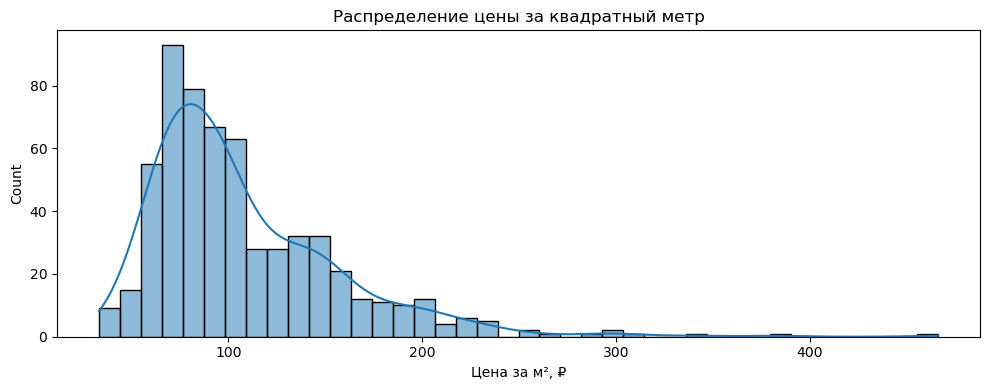

,price,square_meters,price_per_sqm,address,metro
398,6990,15.0,466.00,1-й Красногвардейский проезд,Деловой центр
340,6500,17.0,382.35,Марксистская улица,Марксистская
182,15000,44.0,340.91,Славянская площадь,Китай-Город
441,10900,35.0,311.43,Мясницкая улица,Тургеневская
516,6000,20.0,300.00,2-я Тверская-Ямская улица,Маяковская



Самая дорогая (за м²) и маленькая квартира:
Площадь: 15.0 м²
Цена: 6990 ₽
Цена за м²: 466.00 ₽
Адрес: 1-й Красногвардейский проезд
Метро: Деловой центр


In [2]:
df = pd.read_csv("../data/processed_offers.csv")
df = prepare_dataframe(df)

# 1. Анализ по году постройки
build_summary = analyze_by_build_decade(df)

# 2. Цены по метро и адресу
metro_styled, address_styled = analyze_price_by_location(df)
display(metro_styled)
display(address_styled)

# 3. Цена за квадратный метр
price_sqm_stats, top5_sqm = analyze_price_per_sqm(df)

# 4. Аномалия: минимум по площади, максимум по цене за м²
anomaly_row = find_smallest_most_expensive(df)

# Выводы

1. **Географический драйвер цены**
   - Локация (станция метро, адрес) даёт самый сильный эффект на стоимость аренды:
     - Топ-станции: Деловой центр, Пушкинская, Таганская.
     - Топ-улицы: Славянская площадь, улица Архитектора Щусева, Пресненская набережная.

2. **Возраст дома — признак премиальности**
   - Дома до 1960 г. и постройки 2000–2009 гг. демонстрируют самые высокие средние цены.
   - Средний диапазон цен у 1980–1999 гг. несколько ниже, что может говорить о «стандартном» московском фонде.

3. **Площадь и цена за м²**
   - Медианная цена за метр — около 94 ₽/м²; средняя — ~108 ₽/м².
   - Распределение имеет правый «хвост»: есть квартиры с экстремально высокой ставкой за метр.
   - Анализ цены за м² помогает выявлять объекты-переоценки независимо от общей площади.

4. **Важность качественных признаков**
   - Тип санузла, отделка, наличие удобств (посудомойка, кондиционер, несколько санузлов) добавляют к цене.
   - Предоплата, отсутствие торга и комиссия влияют на сегментацию и дисциплинируют рынок.

5. **Выбросы и аномалии**
   - Во всех числовых характеристиках (цена, площадь, этажность, высота потолков) есть выбросы, требующие внимания при моделировании.
   - Находка самой маленькой (15 м²) и самой дорогой за метр (466 ₽/м²) квартиры подчёркивает разрыв внутри рынка.

6. **Рекомендации**
   - При построении моделей ценообразования учитывать геопризнаки как основные фичи.
   - Отдельно обработать выбросы или применять robust-методы (например, модели с L1-регуляризацией).

---

**Заключение:**
Рынок посуточной аренды в Москве чётко сегментирован по локации и качеству недвижимости. Для прогноза цены ключевыми являются признаки «где» (метро, адрес) и «в чём» (год постройки, отделка, удобства), а чисто количественные метрики (площадь, этаж) выступают второстепенными. Такой комплексный подход позволяет выявить как типовые предложения, так и аномально дорогие объекты, что особенно важно для аналитиков, риэлторов и инвесторов.

# Обсуждение

## Что мы планировали сделать и что удалось реализовать

Целью исследования был анализ рынка **посуточной аренды квартир в Москве** с фокусом на факторы, влияющие на цену. Мы хотели выявить:

- основные драйверы стоимости аренды;
- влияние даты постройки, геопозиции, отделки и удобств;
- крайние и нетипичные случаи (например, переоценённые малогабаритные квартиры).

Удалось реализовать полный цикл:

- провести очистку данных и извлечь признаки из полуструктурированных списков;
- обогатить датасет производными признаками (`price_per_sqm`, `kitchen_ratio` и др.);
- проанализировать распределения, выбросы, категориальные и списковые признаки;
- визуализировать закономерности по географии (`metro`, `address`) и эпохам постройки;
- найти явные аномалии и описать сегменты.

---

## Что не удалось и почему

- Мы не провели **моделирование (ML)** — это было вне фокуса текущей итерации, чтобы не жертвовать качеством EDA и интерпретацией.
- Не все признаки в `amenities` и `building_info` можно было интерпретировать однозначно — они сильно варьируются по формату (в т.ч. вручную введённые строки).
- Не реализована геовизуализация (на карте) — в данных нет координат, только строки адресов. Это усложняет использование `folium`, `mapbox` и т.д.

---

## Как можно было бы улучшить исследование

- Добавить **геокодирование** адресов и визуализировать спрос/цену на карте Москвы.
- Построить модель (линейную регрессию, XGBoost) для оценки важности факторов и прогноза цены.
- Провести кластеризацию квартир по признакам (например, "дешёвые студии", "дорогие элитки").
- Добавить временной анализ (если есть даты публикации) — сезонность, динамику.
- Интеграция с внешними источниками: плотность застройки, инфраструктура, транспортная доступность.

---

## Кому это может быть полезно

- **Пользователям и арендаторам** — чтобы понимать, за что они платят, и как находить разумные предложения.
- **Собственникам и агентствам** — для обоснованного ценообразования и сегментации объектов.
- **Платформам аренды** — как часть рекомендательных систем или фильтров (например, "переоценено", "лучшее соотношение цена/площадь").
- **Data science-специалистам** — как пример подготовки и анализа полуструктурированных данных с множеством категориальных и списковых признаков.

Логика и инструменты исследования переносимы: если вместо аренды квартир у нас был бы анализ гостиниц, рецептов, вакансий или автомобилей — подход остался бы тем же. Главное — извлечение, нормализация, обогащение признаков и интерпретация.